In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_mp=pd.read_csv("/content/drive/MyDrive/D4G/SAISON 13 ECLAIREUR PUBLIC/marches_publics_normalized_data.csv",sep=";",encoding='utf-8',escapechar='\\')

<ipython-input-3-a6b997ab3013>:1: DtypeWarning: Columns (1,2,7,8,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mp=pd.read_csv("/content/drive/MyDrive/D4G/SAISON 13 ECLAIREUR PUBLIC/marches_publics_normalized_data.csv",sep=";",encoding='utf-8',escapechar='\\')


In [ ]:
# Modification du format des colonnes date
# errors='coerce' will set invalid dates to Nat (Not a time)
# format='%Y-%m-%d' explicitly specifies the date format
df_mp['datenotification']=pd.to_datetime(df_mp['datenotification'], errors='coerce', format='%Y-%m-%d')
df_mp['datepublicationdonnees']=pd.to_datetime(df_mp['datepublicationdonnees'], errors='coerce', format='%Y-%m-%d')

In [ ]:
#Je convertis l'ensemble des montants en valeur absolue
#Je leur donne le type float
df_mp['montant']=df_mp['montant'].abs()
df_mp['montant']=df_mp['montant'].astype(float)

In [ ]:
 #Création d'une nouvelle colonne qui indique si la déclaration est obligatoire.
 # Le critère est le montant du marché public. Tous les marchés publics d'un montant supérieur à 40 000 euros doivent être publiés sur le site (depuis 2020)
 df_mp['obligation_publication'] = pd.cut(
        df_mp['montant'],
        bins=[-float('inf'), 40000, float('inf')],
        labels=['Optionnel', 'Obligatoire'],
        right=False)

In [ ]:
# Calule du nombre de jours entre la date de notification et la date de publication des données
df_mp['nbjours']=df_mp['datepublicationdonnees']-df_mp['datenotification']
df_mp['nbjours']=df_mp['nbjours'].fillna('0 days')
df_mp['nbjours'] = df_mp['nbjours'].dt.days.astype('int32')

In [ ]:
#Création d'une colonne avec l'année de la date de notification afin de créer des datasets
# et des agrégations par année

df_mp['annee']=df_mp['datenotification'].dt.year
df_mp['annee']=df_mp['annee'].fillna(0).astype(int)

In [ ]:
# Je veux supprimer les lignes où le nom de l'acheteur est vide
df_mp=df_mp.dropna(subset=['acheteur_nom'])

In [ ]:
# Je supprime toutes les lignes dont les dates sont inférieures à 2018
#annee_analyse = [2018,2019,2020,2021,2022,2023]
#for y in liste_annee:
#    if y not in annee_analyse:
#      liste_annee.remove(y)

df_mp_clean=df_mp[df_mp['annee']>=2018]

In [ ]:
#df_mp_clean=df_mp[df_mp['annee']>=2018]

# Création d'un dictionnaire vide
data={}

# Création d'une liste vide pour pouvoir créer un dataframe à la fin avec l'ensemble des notes
liste=[]

# Création de la liste des collectivités
liste_collectivites=df_mp_clean['acheteur_nom'].unique()


# Création d'un dataset par collectivité
for j in liste_collectivites:
  j=str(j).lower()

  #df=df_mp.loc[df_mp['acheteur_nom'].str.lower() ==j]

  # création de la liste des années

  liste_annee=sorted(df_mp_clean['annee'].unique())
  for y in liste_annee:

    # Création d'un dataset par collectivité et par année pour calculer un score de transperence par année

    df=df_mp.loc[(df_mp['acheteur_nom'].str.lower()==j) & (df_mp['annee']==y)]

    # Score de transparence E pour la présence Code E
    if len(df)==0:
      score_transparence_E=0
    else:
      score_transparence_E=1


  # Score de transparence D Je compte le nombre de valeurs obligatoires = montants supérieurs à 40 000 euros
    counts = df['obligation_publication'].value_counts()
    if 'Obligatoire' in counts and counts['Obligatoire']> 0:
      score_transparence_D=1
    else:
      score_transparence_D=0


# Score de transparence C Je compte le nombre de valeurs optionnelles = montants inférieurs à 40 000 euros

    if 'Optionnel'in counts and counts['Optionnel'] > 0:
      score_transparence_C=1
    else:
      score_transparence_C=0
      #print(score_transparence_C)


      # Score de transpaence B pour la présence des colonnes minimum
    # Liste des colonnes obligatoires pour le score de transparence. On supprime la colonne s'il n'y a pas de donnée dans la colonne
    colonnes_obligatoires=('Unnamed: 0'
                            ,'codecpv'
                            ,'montant'
                            ,'datenotification'
                            ,'lieuexecution_typecode'
                            ,'lieuexecution_code'
                            ,'formeprix'
                            ,'lieuexecution_nom'
                            ,'objet'
                            ,'nature'
                            ,'dureemois'
                            ,'procedure'
                            ,'titulaires'
                              )
#Supression des colonnes vides faisant partie de ces colonnes obligatoires

    df=df.dropna(axis='columns', how='any')
  # Liste des colonnes présentes dans le dataset après avoir supprimé toutes les colonnes vides
    colonnes_obligatoires_left = [col for col in df.columns if col in colonnes_obligatoires]
# Score de complétude = 0 S'il n'y a plus de colonnes et 1 sinon

    if len(colonnes_obligatoires_left) !=13 :
      score_transparence_B=0
    else:
        score_transparence_B=1



# Score de transparence A Nombre de mois entre la date de publication et la date de notification
    duree_mediane= df['nbjours'].median()

    if duree_mediane > 60:
      score_transparence_A=0
    else:
      score_transparence_A=1

# Je calcule le score total pour déduire la note finale
    if score_transparence_E==0:
      Score_total='E'
    else :
      if score_transparence_D==0:
        Score_total='D'
      else :
        if score_transparence_C==0:
          score_total='C'
        else :
          if score_transparence_B==0:
            score_total='B'
          else :
            score_total='A'

    #Score_total=score_transparence_A+score_transparence_B+score_transparence_C+score_transparence_D+score_transparence_E

#J'ajoute les données dans le dictionnaire
    data={ 'collectivité' : j,
          'année' :y,
          'score_transparence_A' : score_transparence_A,
          'score_transparence_B' : score_transparence_B,
          'score_transparence_C': score_transparence_C,
          'score_transparence_D': score_transparence_D,
          'score_transparence_E': score_transparence_E,
          'Score_total':Score_total
                }
    liste.append(data)

df_score=pd.DataFrame(liste)

<Axes: xlabel='Score_total'>

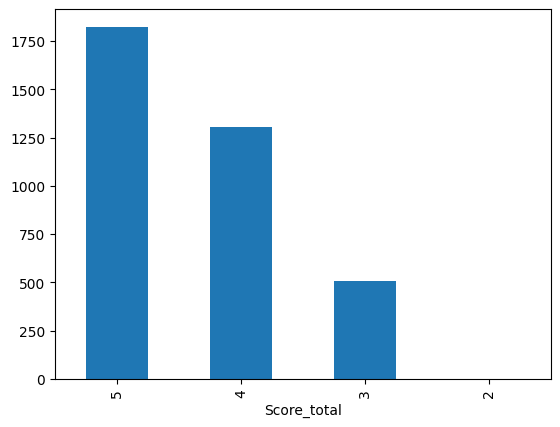

In [ ]:
#Créer un digramme à barre avec le volume de lignes pour chaque valeur du score_total
df_score['Score_total'].value_counts().plot(kind='bar')